### **Importing Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

### **Machine Learning Libraries**

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### **Other Required Libraries**

In [3]:
import re
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

### **Download NLTK resources**

In [4]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Set up color palettes for consistent visualization**

In [5]:
COLOR_PALETTES = {
    'primary': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'],
    'pastel': ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
               '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5'],
    'diverging': ['#d73027', '#fc8d59', '#fee090', '#ffffbf', '#e0f3f8', '#91bfdb', '#4575b4'],
    'qualitative': ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f']
}

plt.style.use('seaborn-v0_8')
sns.set_palette(COLOR_PALETTES['primary'])

### **Data Loading and Initial Exploration**

In [6]:
# Load the dataset
df = pd.read_csv('all_upwork_jobs_2024-02-07-2024-03-24.csv')

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
display(df.info())
print("\nFirst few rows:")
display(df.head())

Dataset Shape: (244828, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244828 entries, 0 to 244827
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   title           244827 non-null  object 
 1   link            244827 non-null  object 
 2   published_date  244828 non-null  object 
 3   is_hourly       244828 non-null  bool   
 4   hourly_low      102422 non-null  float64
 5   hourly_high     98775 non-null   float64
 6   budget          103891 non-null  float64
 7   country         239751 non-null  object 
dtypes: bool(1), float64(3), object(4)
memory usage: 13.3+ MB


None


First few rows:


,title,link,published_date,is_hourly,hourly_low,hourly_high,budget,country
0,Experienced Media Buyer For Solar Pannel and R...,https://www.upwork.com/jobs/Experienced-Media-...,2024-02-17 09:09:54+00:00,False,NaN,NaN,500.0,NaN
1,Full Stack Developer,https://www.upwork.com/jobs/Full-Stack-Develop...,2024-02-17 09:09:17+00:00,False,NaN,NaN,1100.0,United States
2,SMMA Bubble App,https://www.upwork.com/jobs/SMMA-Bubble-App_%7...,2024-02-17 09:08:46+00:00,True,10.0,30.0,NaN,United States
3,Talent Hunter Specialized in Marketing,https://www.upwork.com/jobs/Talent-Hunter-Spec...,2024-02-17 09:08:08+00:00,True,NaN,NaN,NaN,United States
4,Data Engineer,https://www.upwork.com/jobs/Data-Engineer_%7E0...,2024-02-17 09:07:42+00:00,False,NaN,NaN,650.0,India


### **Basic statistics and missing values analysis**

In [7]:
print("Missing Values Analysis:")
missing_data = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df)) * 100
})
print(missing_data)

print("\nBasic Statistics:")
display(df.describe())

Missing Values Analysis:
                Missing Count  Missing Percentage
title                       1            0.000408
link                        1            0.000408
published_date              0            0.000000
is_hourly                   0            0.000000
hourly_low             142406           58.165733
hourly_high            146053           59.655350
budget                 140937           57.565720
country                  5077            2.073701

Basic Statistics:


,hourly_low,hourly_high,budget
count,102422.000000,98775.000000,103891.000000
mean,17.339644,41.970610,911.473564
std,18.140065,47.850892,15729.738834
min,3.000000,3.000000,5.000000
25%,8.000000,20.000000,25.000000
50%,15.000000,30.000000,100.000000
75%,20.000000,50.000000,300.000000
max,998.000000,999.000000,1000000.000000


### **Data Cleaning and Preprocessing**

In [8]:
df_clean = df.copy()

### Handle missing values

In [9]:
print("Before cleaning - Missing values:")
print(df_clean.isnull().sum())

Before cleaning - Missing values:
title                  1
link                   1
published_date         0
is_hourly              0
hourly_low        142406
hourly_high       146053
budget            140937
country             5077
dtype: int64


### Fill missing numerical values with median

In [10]:
numerical_cols = ['hourly_low', 'hourly_high', 'budget']
for col in numerical_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

### Fill missing categorical values

In [11]:
df_clean['country'].fillna('Unknown', inplace=True)

print("\nAfter cleaning - Missing values:")
print(df_clean.isnull().sum())


After cleaning - Missing values:
title             1
link              1
published_date    0
is_hourly         0
hourly_low        0
hourly_high       0
budget            0
country           0
dtype: int64


### **Feature Engineering**

### Extract date features

In [12]:
df_clean['published_date'] = pd.to_datetime(df_clean['published_date'])
df_clean['published_month'] = df_clean['published_date'].dt.month
df_clean['published_year'] = df_clean['published_date'].dt.year
df_clean['published_day'] = df_clean['published_date'].dt.day
df_clean['published_weekday'] = df_clean['published_date'].dt.day_name()

### Create salary features

In [13]:
df_clean['hourly_avg'] = (df_clean['hourly_low'] + df_clean['hourly_high']) / 2
df_clean['has_budget'] = df_clean['budget'] > 0
df_clean['has_hourly_rate'] = (df_clean['hourly_low'] > 0) | (df_clean['hourly_high'] > 0)

### Clean job titles

In [14]:
def clean_job_title(title):
    if pd.isna(title):
        return ""
    title = str(title).lower()
    # Remove special characters and extra spaces
    title = re.sub(r'[^\w\s]', ' ', title)
    title = re.sub(r'\s+', ' ', title)
    return title.strip()

df_clean['clean_title'] = df_clean['title'].apply(clean_job_title)

print("Feature engineering completed!")
print(f"Dataset shape after preprocessing: {df_clean.shape}")

def extract_keywords(text, num_words=20):
    words = text.split()
    stop_words = set(stopwords.words('english'))
    keywords = [word for word in words if word not in stop_words and len(word) > 2]
    return Counter(keywords).most_common(num_words)

# Get all titles text
all_titles = ' '.join(df_clean['clean_title'].dropna())
common_keywords = extract_keywords(all_titles)

print("Most common job title keywords:")

for word, count in common_keywords[:15]:
    print(f"{word}: {count}")

Feature engineering completed!
Dataset shape after preprocessing: (244828, 16)
Most common job title keywords:
needed: 17592
website: 16865
developer: 16062
expert: 15021
video: 14138
design: 13269
designer: 12957
need: 10237
amp: 9689
specialist: 9032
looking: 8747
marketing: 8416
app: 8282
media: 8261
editor: 8073


### **Task 1: Analyze correlation between job title keywords and salaries**

### Extract keywords from job titles

In [15]:
def extract_keywords(text, num_words=20):
    words = text.split()
    stop_words = set(stopwords.words('english'))
    keywords = [word for word in words if word not in stop_words and len(word) > 2]
    return Counter(keywords).most_common(num_words)

# Get all titles text
all_titles = ' '.join(df_clean['clean_title'].dropna())
common_keywords = extract_keywords(all_titles)

print("Most common job title keywords:")

for word, count in common_keywords[:15]:
    print(f"{word}: {count}")

Most common job title keywords:
needed: 17592
website: 16865
developer: 16062
expert: 15021
video: 14138
design: 13269
designer: 12957
need: 10237
amp: 9689
specialist: 9032
looking: 8747
marketing: 8416
app: 8282
media: 8261
editor: 8073


### Create keyword-salary correlation analysis

In [16]:
keyword_salary_data = []

for keyword, _ in common_keywords[:20]:
    keyword_mask = df_clean['clean_title'].str.contains(keyword, na=False)
    keyword_jobs = df_clean[keyword_mask]

    if len(keyword_jobs) > 5:  # Only consider keywords with sufficient data
        avg_budget = keyword_jobs['budget'].mean()
        avg_hourly = keyword_jobs['hourly_avg'].mean()
        count = len(keyword_jobs)

        keyword_salary_data.append({
            'keyword': keyword,
            'avg_budget': avg_budget,
            'avg_hourly': avg_hourly,
            'job_count': count
        })

keyword_df = pd.DataFrame(keyword_salary_data)

### Enhanced Keyword-Salary Correlation Analysis

In [17]:
def enhanced_keyword_analysis(df, top_n=20):
    """Comprehensive keyword-salary correlation analysis"""
    
    # Extract keywords from all titles
    all_titles = ' '.join(df['clean_title'].dropna())
    common_keywords = extract_keywords(all_titles, num_words=50)
    
    keyword_analysis_data = []
    
    for keyword, count in common_keywords[:top_n]:
        keyword_mask = df['clean_title'].str.contains(r'\b' + keyword + r'\b', na=False)
        keyword_jobs = df[keyword_mask]
        
        if len(keyword_jobs) > 10:  # Minimum threshold for statistical significance
            avg_budget = keyword_jobs['budget'].mean()
            avg_hourly = keyword_jobs['hourly_avg'].mean()
            median_hourly = keyword_jobs['hourly_avg'].median()
            job_count = len(keyword_jobs)
            
            # Calculate salary range
            hourly_std = keyword_jobs['hourly_avg'].std()
            
            keyword_analysis_data.append({
                'keyword': keyword,
                'avg_budget': avg_budget,
                'avg_hourly': avg_hourly,
                'median_hourly': median_hourly,
                'hourly_std': hourly_std,
                'job_count': job_count,
                'budget_job_ratio': avg_budget / job_count if job_count > 0 else 0
            })
    
    return pd.DataFrame(keyword_analysis_data)

# Perform enhanced analysis
enhanced_keyword_df = enhanced_keyword_analysis(df_clean)

print("Top 10 Keywords by Average Hourly Rate:")
display(enhanced_keyword_df.nlargest(10, 'avg_hourly')[['keyword', 'avg_hourly', 'median_hourly', 'job_count']])

print("\nTop 10 Keywords by Job Count:")
display(enhanced_keyword_df.nlargest(10, 'job_count')[['keyword', 'job_count', 'avg_hourly', 'median_hourly']])


Top 10 Keywords by Average Hourly Rate:


,keyword,avg_hourly,median_hourly,job_count
3,expert,27.292358,22.5,14944
0,needed,26.128738,22.5,17555
2,developer,25.868783,22.5,16004
11,marketing,25.497887,22.5,8283
7,need,25.288269,22.5,10178
5,design,25.058984,22.5,13046
6,designer,24.868035,22.5,12867
8,amp,24.837169,22.5,9341
10,looking,24.795108,22.5,8729
12,app,24.723428,22.5,7922



Top 10 Keywords by Job Count:


,keyword,job_count,avg_hourly,median_hourly
0,needed,17555,26.128738,22.5
1,website,16526,24.177871,22.5
2,developer,16004,25.868783,22.5
3,expert,14944,27.292358,22.5
4,video,13511,23.235031,22.5
5,design,13046,25.058984,22.5
6,designer,12867,24.868035,22.5
7,need,10178,25.288269,22.5
8,amp,9341,24.837169,22.5
9,specialist,9014,24.409474,22.5


### **Visualizations for Task 1**

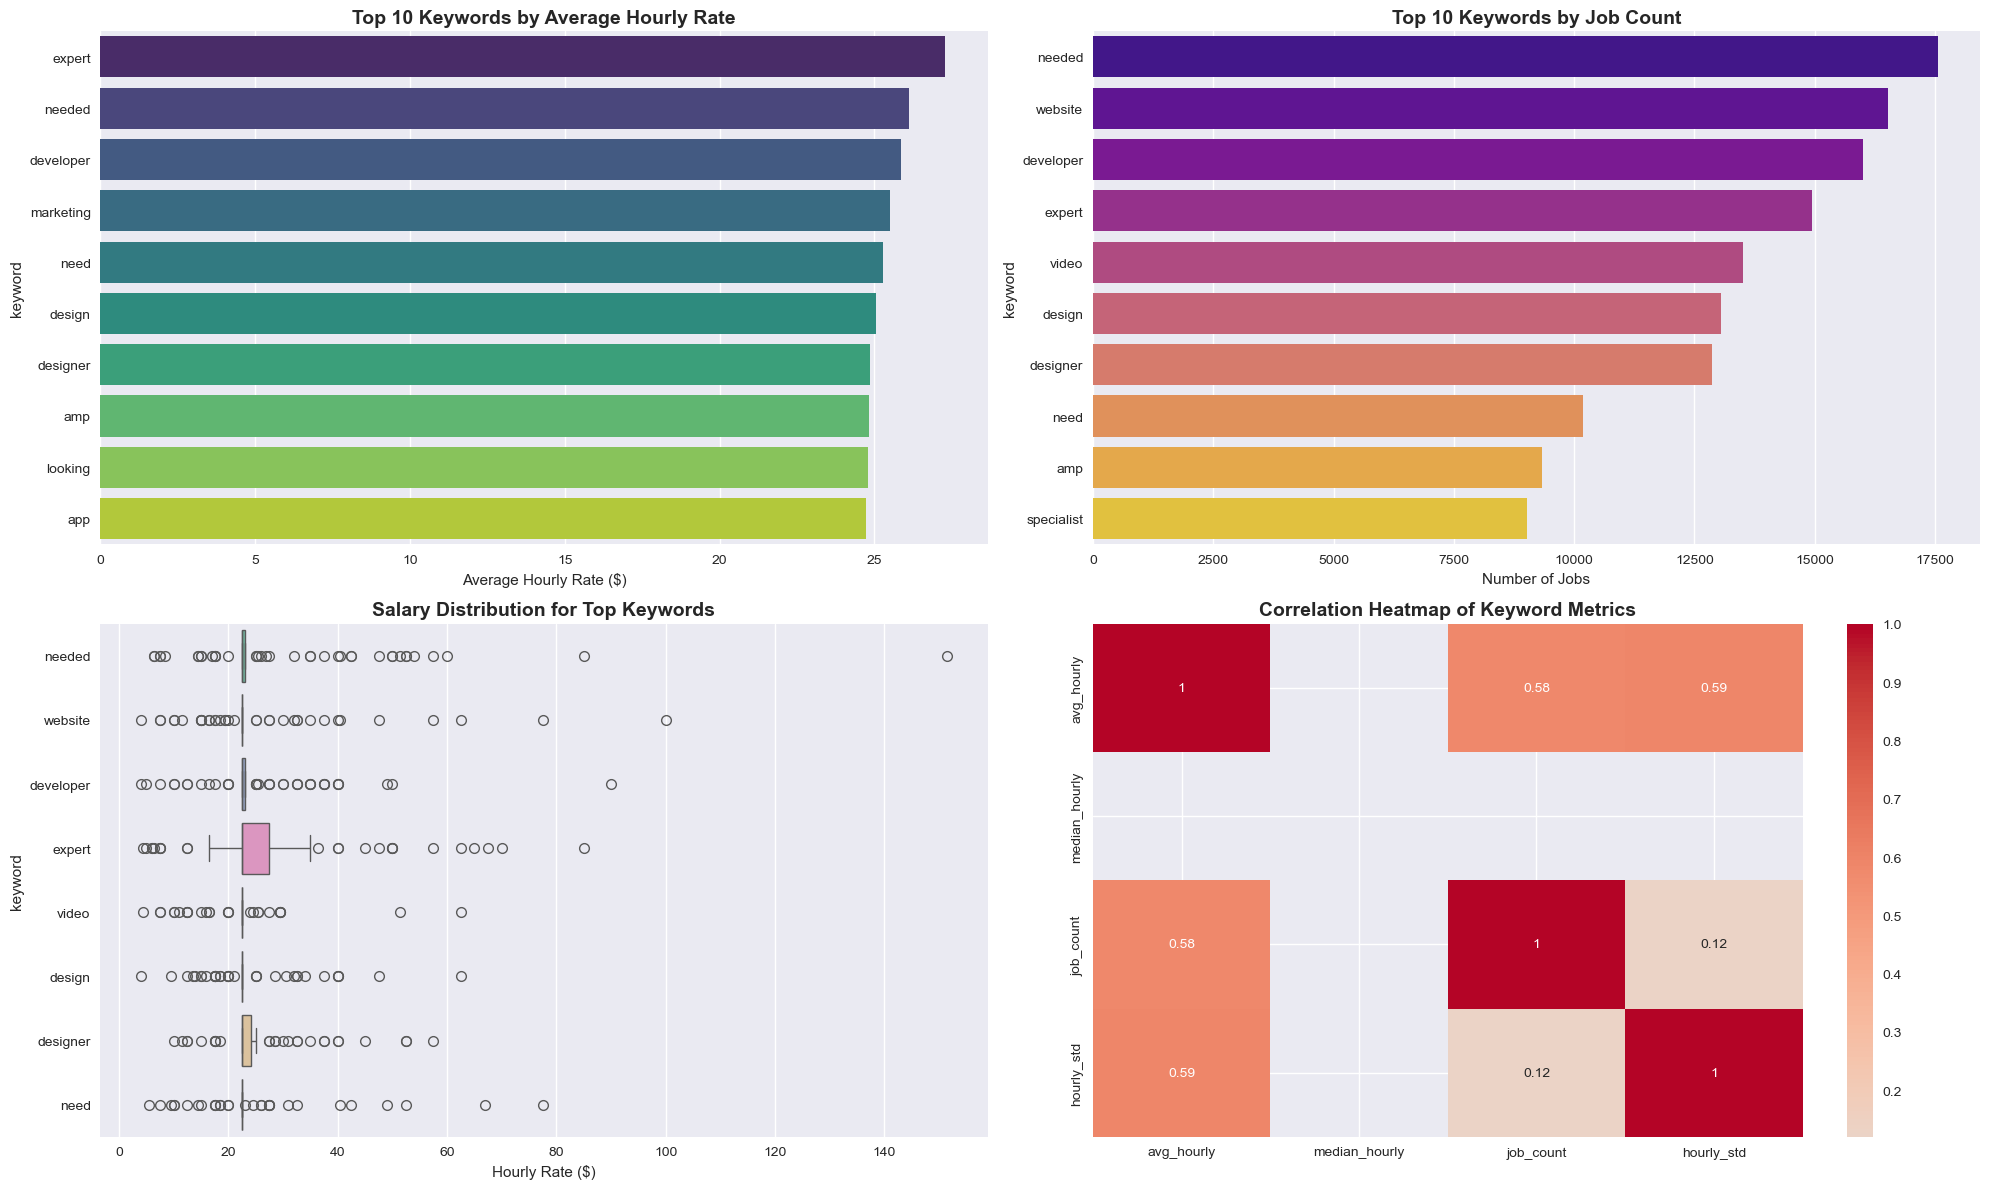

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
# 1. Top keywords by average hourly rate
top_hourly = enhanced_keyword_df.nlargest(10, 'avg_hourly')
sns.barplot(data=top_hourly, x='avg_hourly', y='keyword', ax=ax1, palette='viridis')
ax1.set_title('Top 10 Keywords by Average Hourly Rate', fontsize=14, fontweight='bold')
ax1.set_xlabel('Average Hourly Rate ($)')

# 2. Top keywords by job count
top_count = enhanced_keyword_df.nlargest(10, 'job_count')
sns.barplot(data=top_count, x='job_count', y='keyword', ax=ax2, palette='plasma')
ax2.set_title('Top 10 Keywords by Job Count', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Jobs')

# 3. Salary distribution for top keywords
top_keywords_list = enhanced_keyword_df.nlargest(8, 'job_count')['keyword'].tolist()
salary_data = []
for keyword in top_keywords_list:
    keyword_jobs = df_clean[df_clean['clean_title'].str.contains(r'\b' + keyword + r'\b', na=False)]
    for hourly_rate in keyword_jobs['hourly_avg'].dropna().head(100):  # Sample for visualization
        salary_data.append({'keyword': keyword, 'hourly_rate': hourly_rate})
    
salary_df = pd.DataFrame(salary_data)
sns.boxplot(data=salary_df, x='hourly_rate', y='keyword', ax=ax3, palette='Set2')
ax3.set_title('Salary Distribution for Top Keywords', fontsize=14, fontweight='bold')
ax3.set_xlabel('Hourly Rate ($)')

# 4. Correlation heatmap
correlation_data = enhanced_keyword_df[['avg_hourly', 'median_hourly', 'job_count', 'hourly_std']].corr()
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, ax=ax4)
ax4.set_title('Correlation Heatmap of Keyword Metrics', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Statistical summary

In [20]:
print("Statistical Summary of Keyword Analysis:")
print(f"Total keywords analyzed: {len(enhanced_keyword_df)}")
print(f"Average hourly rate across all keywords: ${enhanced_keyword_df['avg_hourly'].mean():.2f}")
print(f"Highest paying keyword: {enhanced_keyword_df.loc[enhanced_keyword_df['avg_hourly'].idxmax(), 'keyword']} (${enhanced_keyword_df['avg_hourly'].max():.2f})")
print(f"Most frequent keyword: {enhanced_keyword_df.loc[enhanced_keyword_df['job_count'].idxmax(), 'keyword']} ({enhanced_keyword_df['job_count'].max()} jobs)")

Statistical Summary of Keyword Analysis:
Total keywords analyzed: 20
Average hourly rate across all keywords: $24.25
Highest paying keyword: expert ($27.29)
Most frequent keyword: needed (17555 jobs)


### **Task 2: Identify emerging job categories based on posting frequency**

In [21]:
def analyze_emerging_categories(df, min_jobs=50):
    """Analyze job categories and identify emerging trends"""
    
    # Extract broader categories from keywords
    tech_keywords = ['developer', 'software', 'programming', 'python', 'java', 'web', 'app', 'mobile']
    design_keywords = ['design', 'designer', 'ui', 'ux', 'graphic', 'creative']
    marketing_keywords = ['marketing', 'seo', 'social media', 'content', 'digital', 'ads']
    data_keywords = ['data', 'analysis', 'analyst', 'science', 'machine learning', 'ai']
    writing_keywords = ['writer', 'content', 'copy', 'editor', 'blog']
    admin_keywords = ['virtual', 'assistant', 'admin', 'administrative', 'office']
    
    categories = {
        'Technology': tech_keywords,
        'Design': design_keywords,
        'Marketing': marketing_keywords,
        'Data Science': data_keywords,
        'Writing': writing_keywords,
        'Administrative': admin_keywords
    }
    
    # Analyze category trends over time
    category_trends = []
    
    for category, keywords in categories.items():
        # Create pattern for category matching
        pattern = '|'.join([r'\b' + kw + r'\b' for kw in keywords])
        category_mask = df['clean_title'].str.contains(pattern, case=False, na=False)
        
        if category_mask.sum() >= min_jobs:
            category_jobs = df[category_mask]
            
            # Monthly trend analysis
            monthly_trend = category_jobs.groupby('published_month').size()
            
            category_trends.append({
                'category': category,
                'total_jobs': len(category_jobs),
                'avg_hourly_rate': category_jobs['hourly_avg'].mean(),
                'growth_rate': (monthly_trend.iloc[-1] / monthly_trend.iloc[0] - 1) if len(monthly_trend) > 1 else 0,
                'keywords': keywords
            })
    
    return pd.DataFrame(category_trends)

# Perform category analysis
category_df = analyze_emerging_categories(df_clean)
category_df = category_df.sort_values('growth_rate', ascending=False)

print("Emerging Job Categories by Growth Rate:")
display(category_df[['category', 'total_jobs', 'growth_rate', 'avg_hourly_rate']])

Emerging Job Categories by Growth Rate:


,category,total_jobs,growth_rate,avg_hourly_rate
1,Design,27520,3248.800000,24.971221
0,Technology,30542,1377.307692,25.557315
5,Administrative,8734,415.583333,18.678212
4,Writing,19744,0.000000,23.642904
2,Marketing,29522,-0.500000,24.387660
3,Data Science,12873,-0.857143,25.250641


### **Visualization for emerging categories**

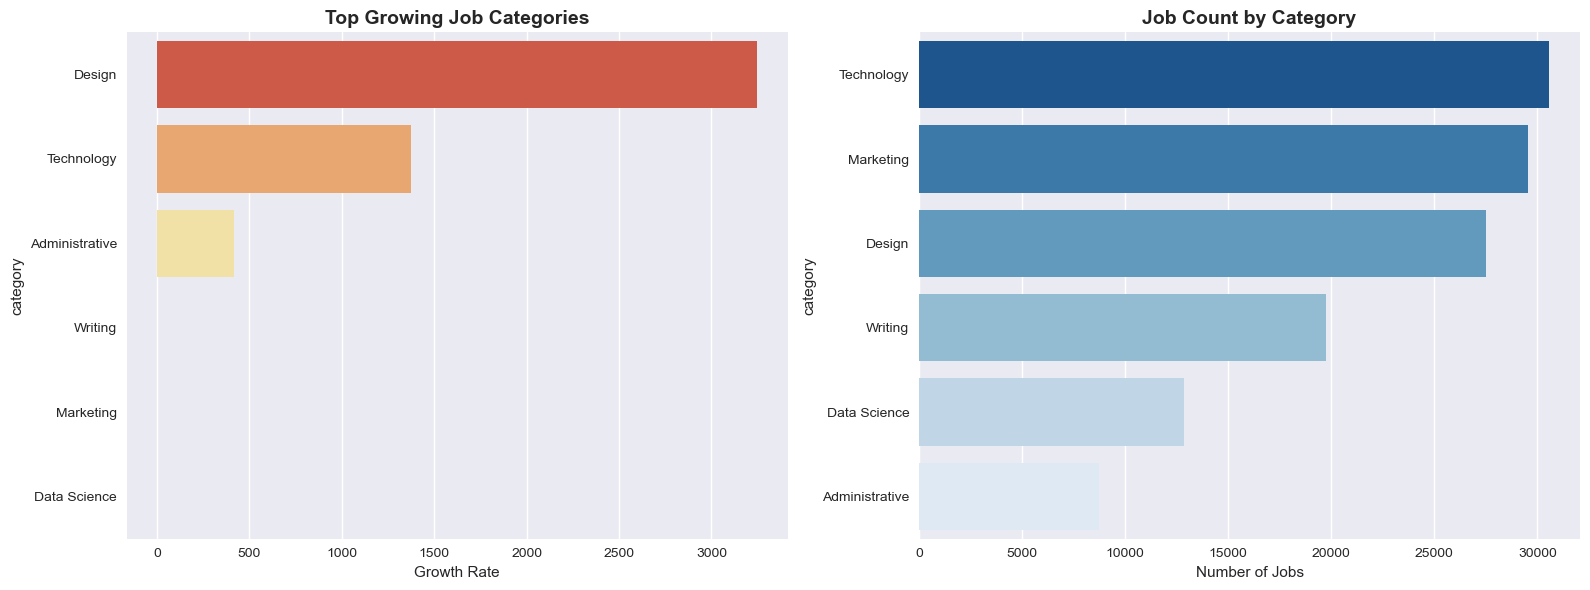

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Growth rate visualization
sns.barplot(data=category_df.nlargest(10, 'growth_rate'), 
            x='growth_rate', y='category', ax=ax1, palette='RdYlGn')
ax1.set_title('Top Growing Job Categories', fontsize=14, fontweight='bold')
ax1.set_xlabel('Growth Rate')

# Job count by category
sns.barplot(data=category_df.nlargest(10, 'total_jobs'), 
            x='total_jobs', y='category', ax=ax2, palette='Blues_r')
ax2.set_title('Job Count by Category', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Jobs')

plt.tight_layout()
plt.show()

### **Task 3: Predict high-demand job roles using time series analysis**

### Importing required libraries

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [25]:
def predict_high_demand_roles(df, forecast_months=3):
    """Predict high-demand job roles using time series analysis"""
    
    # Get top job titles by frequency
    top_titles = df['clean_title'].value_counts().head(30).index.tolist()
    
    prediction_results = []
    
    for title in top_titles:
        title_jobs = df[df['clean_title'] == title]
        
        if len(title_jobs) >= 10:  # Minimum data points
            # Monthly frequency
            monthly_data = title_jobs.groupby('published_month').size().reset_index()
            monthly_data.columns = ['month', 'count']
            
            if len(monthly_data) >= 3:  # Need at least 3 months for trend analysis
                # Prepare features for prediction
                X = monthly_data[['month']]
                y = monthly_data['count']
                
                # Train linear regression model
                model = LinearRegression()
                model.fit(X, y)
                
                # Predict next months
                future_months = [[month] for month in range(monthly_data['month'].max() + 1, 
                                                          monthly_data['month'].max() + 1 + forecast_months)]
                future_predictions = model.predict(future_months)
                
                # Calculate growth metrics
                current_demand = monthly_data['count'].iloc[-1]
                predicted_demand = future_predictions.mean()
                growth_trend = model.coef_[0]  # Slope of the trend line
                
                prediction_results.append({
                    'job_title': title,
                    'current_demand': current_demand,
                    'predicted_demand': max(0, predicted_demand),  # Ensure non-negative
                    'growth_trend': growth_trend,
                    'avg_salary': title_jobs['hourly_avg'].mean(),
                    'total_postings': len(title_jobs)
                })
    
    return pd.DataFrame(prediction_results)

# Perform demand prediction
demand_predictions = predict_high_demand_roles(df_clean)
demand_predictions = demand_predictions.sort_values('predicted_demand', ascending=False)

print("High-Demand Job Role Predictions:")
display(demand_predictions.head(15))

High-Demand Job Role Predictions:


,job_title,current_demand,predicted_demand,growth_trend,avg_salary,total_postings
0,virtual assistant,199,434.333333,99.0,15.830097,412


### **Visualization for demand predictions**

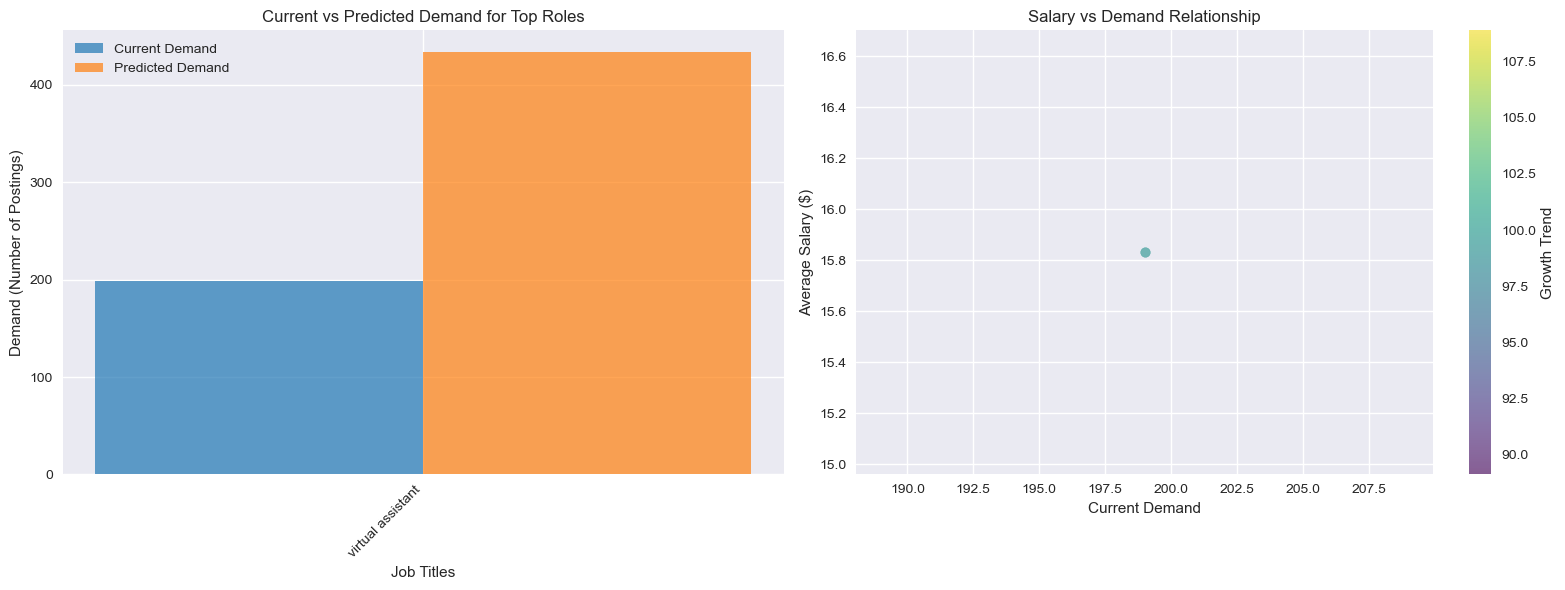

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Current vs Predicted Demand
top_demand = demand_predictions.head(10)
x_pos = np.arange(len(top_demand))
width = 0.35

ax1.bar(x_pos - width/2, top_demand['current_demand'], width, label='Current Demand', alpha=0.7)
ax1.bar(x_pos + width/2, top_demand['predicted_demand'], width, label='Predicted Demand', alpha=0.7)
ax1.set_xlabel('Job Titles')
ax1.set_ylabel('Demand (Number of Postings)')
ax1.set_title('Current vs Predicted Demand for Top Roles')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([title[:20] + '...' if len(title) > 20 else title for title in top_demand['job_title']], 
                   rotation=45, ha='right')
ax1.legend()

# Salary vs Demand scatter plot
ax2.scatter(demand_predictions['current_demand'], demand_predictions['avg_salary'], 
           alpha=0.6, c=demand_predictions['growth_trend'], cmap='viridis')
ax2.set_xlabel('Current Demand')
ax2.set_ylabel('Average Salary ($)')
ax2.set_title('Salary vs Demand Relationship')
plt.colorbar(ax2.collections[0], ax=ax2, label='Growth Trend')

plt.tight_layout()
plt.show()

### Model performance metrics

In [27]:
print("\nDemand Prediction Summary:")
print(f"Total roles analyzed: {len(demand_predictions)}")
print(f"Average predicted growth: {demand_predictions['growth_trend'].mean():.2f}")
print(f"Highest growth role: {demand_predictions.loc[demand_predictions['growth_trend'].idxmax(), 'job_title']}")


Demand Prediction Summary:
Total roles analyzed: 1
Average predicted growth: 99.00
Highest growth role: virtual assistant


### **Task 4: Compare average hourly rates across different countries**

In [28]:
def analyze_country_salaries(df, min_jobs=10):
    """Analyze and compare hourly rates across different countries"""
    
    # Filter countries with sufficient data
    country_stats = df[df['country'] != 'Unknown'].groupby('country').agg({
        'hourly_avg': ['count', 'mean', 'median', 'std'],
        'budget': 'mean',
        'clean_title': 'count'
    }).round(2)
    
    # Flatten column names
    country_stats.columns = ['_'.join(col).strip() for col in country_stats.columns.values]
    country_stats = country_stats.rename(columns={'clean_title_count': 'job_count'})
    
    # Filter countries with minimum job count
    country_stats = country_stats[country_stats['job_count'] >= min_jobs]
    country_stats = country_stats.sort_values('hourly_avg_mean', ascending=False)
    
    return country_stats

# Perform country salary analysis
country_salary_df = analyze_country_salaries(df_clean)

print("Average Hourly Rates by Country:")
display(country_salary_df.head(15))

Average Hourly Rates by Country:


,hourly_avg_count,hourly_avg_mean,hourly_avg_median,hourly_avg_std,budget_mean,job_count
country,,,,,,
Malaysia,903,31.66,22.5,37.63,476.07,903
Thailand,724,30.32,22.5,27.74,289.37,724
British Virgin Islands,24,29.15,22.5,14.28,282.08,24
Myanmar,11,28.05,22.5,14.14,284.09,11
Zambia,68,28.04,22.5,20.51,337.87,68
Guatemala,38,28.00,22.5,16.33,164.97,38
United States,99834,27.22,22.5,22.80,361.76,99834
United States Virgin Islands,17,27.21,22.5,23.96,134.12,17
Cayman Islands,46,26.60,22.5,12.22,556.63,46


### **Visualization for country salary comparison**

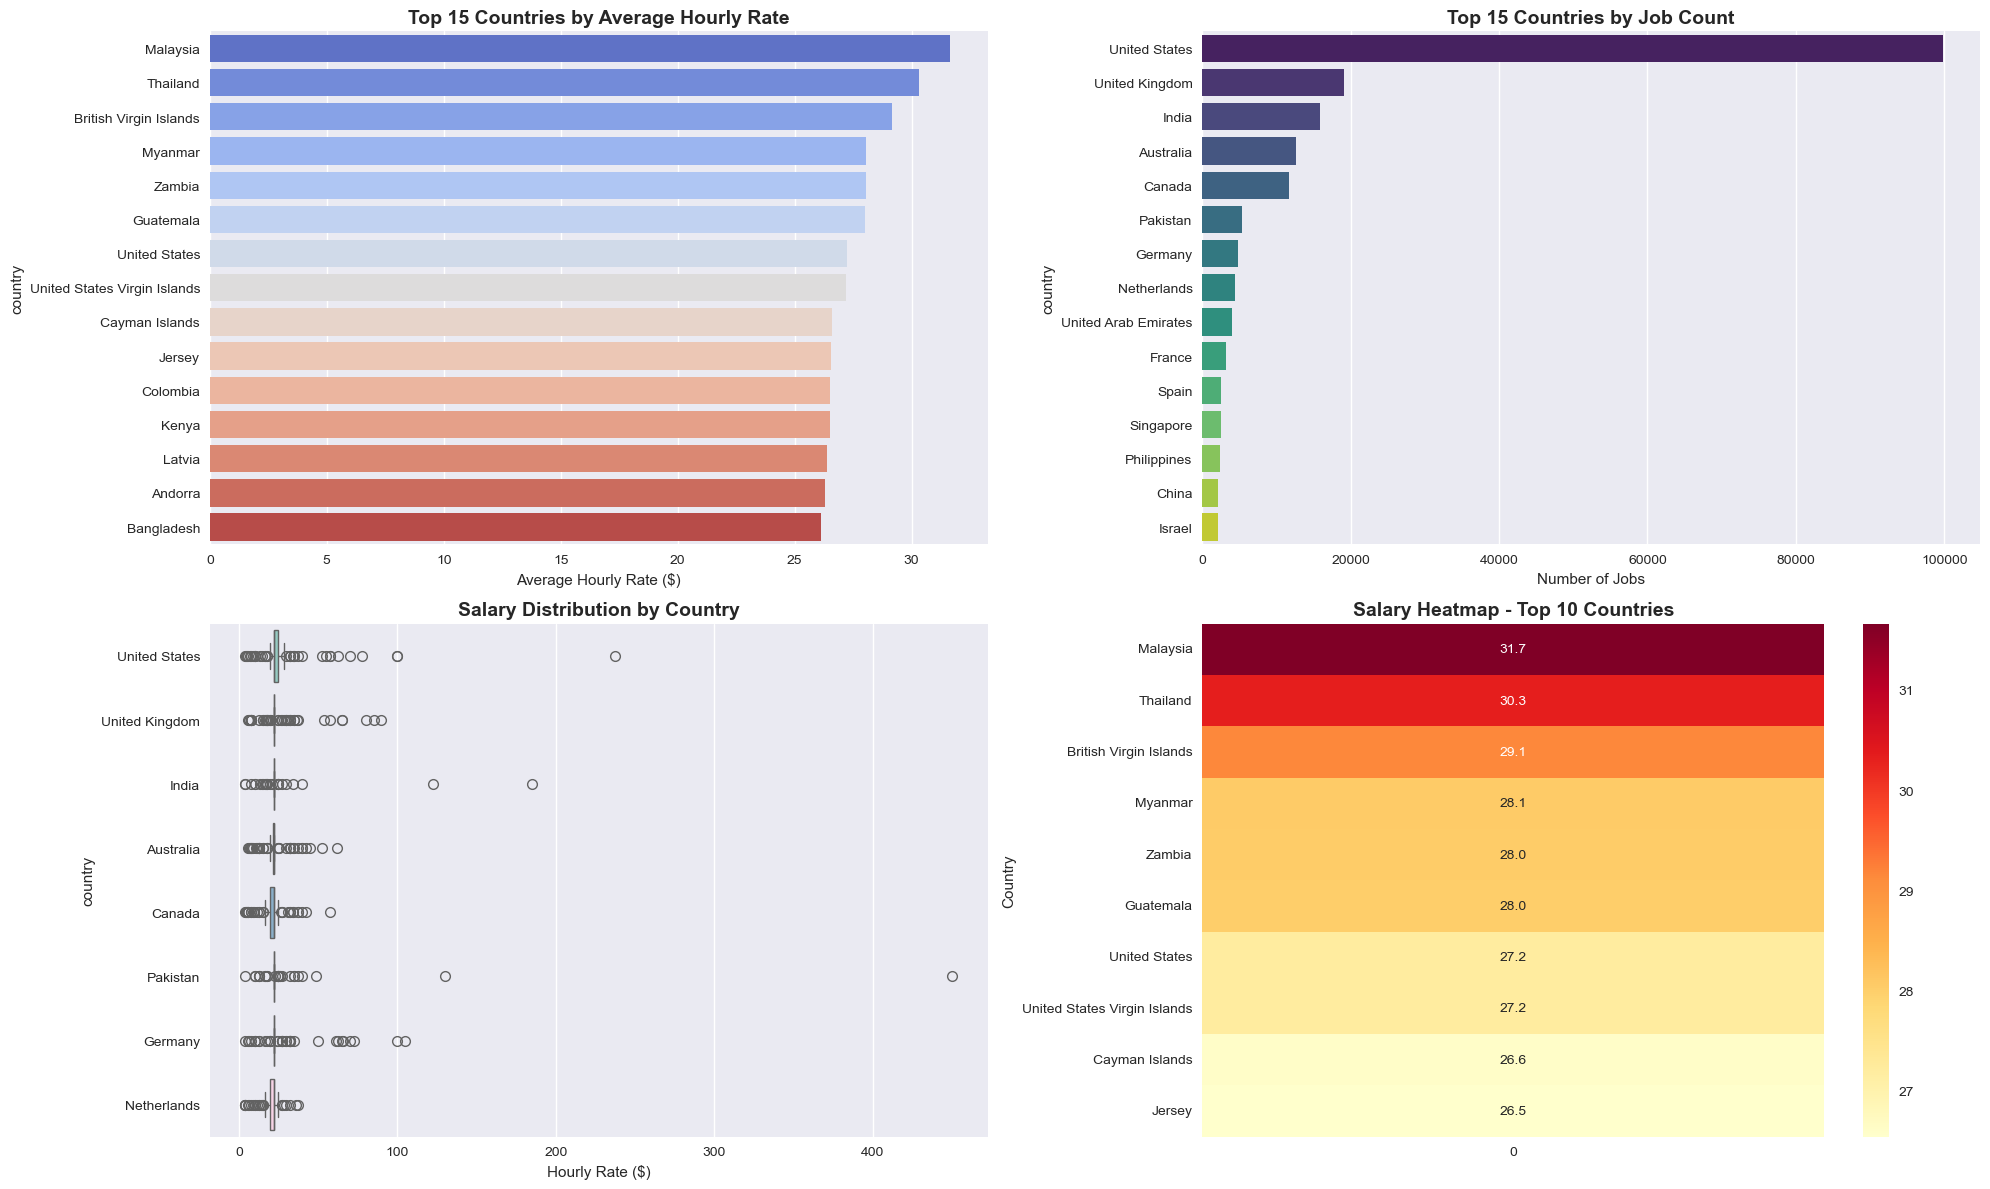

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Top countries by average hourly rate
top_countries = country_salary_df.nlargest(15, 'hourly_avg_mean')
sns.barplot(data=top_countries.reset_index(), x='hourly_avg_mean', y='country', 
            ax=ax1, palette='coolwarm')
ax1.set_title('Top 15 Countries by Average Hourly Rate', fontsize=14, fontweight='bold')
ax1.set_xlabel('Average Hourly Rate ($)')

# Job count by country
top_countries_jobs = country_salary_df.nlargest(15, 'job_count').reset_index()
sns.barplot(data=top_countries_jobs, x='job_count', y='country', 
            ax=ax2, palette='viridis')
ax2.set_title('Top 15 Countries by Job Count', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Jobs')

# Salary distribution by top countries
top_country_list = country_salary_df.nlargest(8, 'job_count').index.tolist()
salary_by_country = []
for country in top_country_list:
    country_jobs = df_clean[df_clean['country'] == country]
    for hourly_rate in country_jobs['hourly_avg'].dropna().head(100):
        salary_by_country.append({'country': country, 'hourly_rate': hourly_rate})
    
salary_country_df = pd.DataFrame(salary_by_country)
sns.boxplot(data=salary_country_df, x='hourly_rate', y='country', ax=ax3, palette='Set3')
ax3.set_title('Salary Distribution by Country', fontsize=14, fontweight='bold')
ax3.set_xlabel('Hourly Rate ($)')

# Geographical salary heatmap (simplified)
country_avg = country_salary_df['hourly_avg_mean'].head(10)
sns.heatmap(country_avg.values.reshape(-1, 1), 
            annot=True, fmt='.1f', cmap='YlOrRd', 
            yticklabels=country_avg.index, ax=ax4)
ax4.set_title('Salary Heatmap - Top 10 Countries', fontsize=14, fontweight='bold')
ax4.set_ylabel('Country')

plt.tight_layout()
plt.show()

### Statistical summary

In [30]:
print("\nCountry Salary Analysis Summary:")
print(f"Total countries with sufficient data: {len(country_salary_df)}")
print(f"Highest paying country: {country_salary_df['hourly_avg_mean'].idxmax()} (${country_salary_df['hourly_avg_mean'].max():.2f})")
print(f"Lowest paying country: {country_salary_df['hourly_avg_mean'].idxmin()} (${country_salary_df['hourly_avg_mean'].min():.2f})")
print(f"Global average hourly rate: ${country_salary_df['hourly_avg_mean'].mean():.2f}")


Country Salary Analysis Summary:
Total countries with sufficient data: 157
Highest paying country: Malaysia ($31.66)
Lowest paying country: Brunei Darussalam ($15.88)
Global average hourly rate: $23.62


### **Task 5: Create a job recommendation engine**

### Importing required libraries

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [33]:
class JobRecommendationEngine:
    def __init__(self, df):
        self.df = df.copy()
        self.tfidf_vectorizer = None
        self.job_vectors = None
        self._prepare_data()
    
    def _prepare_data(self):
        """Prepare data for recommendation engine"""
        # Combine title and country for better recommendations
        self.df['content'] = self.df['clean_title'] + ' ' + self.df['country'].fillna('')
        
        # TF-IDF Vectorization
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        
        self.job_vectors = self.tfidf_vectorizer.fit_transform(self.df['content'])
    
    def recommend_jobs(self, query, top_n=10, country_filter=None, salary_threshold=None):
        """Recommend jobs based on query similarity"""
        
        # Transform query to TF-IDF vector
        query_vector = self.tfidf_vectorizer.transform([query])
        
        # Calculate cosine similarity
        similarities = cosine_similarity(query_vector, self.job_vectors).flatten()
        
        # Create results dataframe
        results = self.df.copy()
        results['similarity'] = similarities
        
        # Apply filters
        if country_filter:
            results = results[results['country'].str.contains(country_filter, case=False, na=False)]
        
        if salary_threshold:
            results = results[results['hourly_avg'] >= salary_threshold]
        
        # Sort by similarity and return top results
        recommendations = results.nlargest(top_n, 'similarity')[
            ['title', 'country', 'hourly_avg', 'budget', 'similarity', 'published_date', 'clean_title']
        ]
        
        return recommendations
    
    def get_similar_jobs(self, job_index, top_n=10):
        """Get similar jobs based on a specific job index"""
        similarities = cosine_similarity(self.job_vectors[job_index:job_index+1], self.job_vectors).flatten()
        
        similar_indices = similarities.argsort()[-top_n-1:-1][::-1]
        
        similar_jobs = self.df.iloc[similar_indices][
            ['title', 'country', 'hourly_avg', 'budget', 'published_date']
        ]
        similar_jobs['similarity'] = similarities[similar_indices]
        
        return similar_jobs
    
    def cluster_jobs(self, n_clusters=10):
        """Cluster jobs into categories"""
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(self.job_vectors)
        
        self.df['cluster'] = clusters
        return self.df.groupby('cluster').agg({
            'clean_title': 'count',
            'hourly_avg': 'mean',
            'country': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
        }).rename(columns={'clean_title': 'job_count'})

### Initialize recommendation engine

In [34]:
recommendation_engine = JobRecommendationEngine(df_clean)

# Test the recommendation engine
print("Job Recommendations for 'Python Developer':")
python_recommendations = recommendation_engine.recommend_jobs(
    'python developer', 
    top_n=10, 
    salary_threshold=20
)
display(python_recommendations)

Job Recommendations for 'Python Developer':


,title,country,hourly_avg,budget,similarity,published_date,clean_title
84308,"Python Developer with PYPDF2, FillPdf etc",United States,22.5,100.0,0.954848,2024-02-29 01:16:31+00:00,python developer with pypdf2 fillpdf etc
84536,Python Developer - Z3 Solver,India,22.5,20.0,0.939114,2024-02-28 05:28:09+00:00,python developer z3 solver
91187,Python Developer - Z3 Solver,India,22.5,20.0,0.939114,2024-02-28 22:42:51+00:00,python developer z3 solver
201523,Python developer. with more then 4 years exper...,India,37.5,100.0,0.939114,2024-03-15 14:38:39+00:00,python developer with more then 4 years experi...
172600,Python Developer,Australia,25.0,100.0,0.932054,2024-03-14 13:43:01+00:00,python developer
114362,Python Developer,Canada,22.5,80.0,0.929879,2024-03-03 04:52:26+00:00,python developer
95433,Python Developer,Pakistan,23.5,100.0,0.903687,2024-03-01 11:14:34+00:00,python developer
151718,Python Developer,Pakistan,25.5,100.0,0.903687,2024-03-14 10:58:47+00:00,python developer
208678,Python Developer,Unknown,25.5,100.0,0.901976,2024-03-20 20:52:28+00:00,python developer
236442,Python Developer ( with certification),Unknown,25.5,100.0,0.901976,2024-03-22 13:05:11+00:00,python developer with certification


In [35]:
print("\nJob Recommendations for 'Data Scientist':")
data_science_recommendations = recommendation_engine.recommend_jobs(
    'data scientist', 
    top_n=8,
    country_filter='United States'
)
display(data_science_recommendations)


Job Recommendations for 'Data Scientist':


,title,country,hourly_avg,budget,similarity,published_date,clean_title
57300,Data Visualization of Mapping Data,United States,29.5,100.0,0.944879,2024-02-23 17:47:16+00:00,data visualization of mapping data
183570,Turn data into PowerBI or simliar for data vis...,United States,22.5,5000.0,0.944879,2024-03-21 16:24:51+00:00,turn data into powerbi or simliar for data vis...
166323,Data Scientist Needed for DICOM/nifti Data Reg...,United States,87.5,100.0,0.884525,2024-03-20 13:20:03+00:00,data scientist needed for dicom nifti data reg...
123016,Data Analysts - Find Recent Entertainment Data...,United States,9.0,100.0,0.825686,2024-03-04 19:14:32+00:00,data analysts find recent entertainment data a...
142466,Data Analysts - Find Recent Entertainment Data...,United States,11.5,100.0,0.825686,2024-03-06 07:14:02+00:00,data analysts find recent entertainment data a...
167043,Data Analysts - Find Recent Entertainment Data...,United States,6.5,100.0,0.825686,2024-03-13 06:17:48+00:00,data analysts find recent entertainment data s...
87096,"data management, EDC system and data monitor f...",United States,22.5,5000.0,0.822858,2024-02-26 23:13:10+00:00,data management edc system and data monitor fo...
5173,Data Processing-Name Matching,United States,22.5,200.0,0.821910,2024-02-17 02:54:10+00:00,data processing name matching


### Test similar jobs

In [36]:
print("\nJobs Similar to First Job in Dataset:")
similar_jobs = recommendation_engine.get_similar_jobs(0, top_n=5)
display(similar_jobs)


Jobs Similar to First Job in Dataset:


,title,country,hourly_avg,budget,published_date,similarity
211409,Solar Facebook media buyer,India,17.5,100.0,2024-03-17 09:48:24+00:00,0.715404
43824,Media buyer,Unknown,22.5,300.0,2024-02-22 15:04:01+00:00,0.709790
244705,Experienced Pay Per Call Media Buyer,United States,22.5,5000.0,2024-03-24 13:35:09+00:00,0.689442
55586,Experienced YouTube Ads Media Buyer For Solar ...,India,22.5,600.0,2024-02-21 14:50:17+00:00,0.677849
12998,Nutra COD Media Buyer India,Unknown,77.5,100.0,2024-02-17 17:06:38+00:00,0.676569


### Cluster analysis

In [37]:
job_clusters = recommendation_engine.cluster_jobs(n_clusters=8)
display(job_clusters.sort_values('hourly_avg', ascending=False))

,job_count,hourly_avg,country
cluster,,,
1,83231,27.608655,United States
6,6634,26.091498,United States
5,17367,25.764899,United Kingdom
3,11366,25.231656,United States
0,106375,24.168531,India
7,6412,23.609170,United States
4,6436,22.389062,United States
2,7007,21.123091,United States


### **Task 6: Track changes in job market dynamics over months**

In [38]:
def analyze_market_dynamics(df):
    """Analyze job market dynamics over time"""
    
    # Monthly trends
    monthly_trends = df.groupby('published_month').agg({
        'clean_title': 'count',
        'hourly_avg': 'mean',
        'budget': 'mean',
        'country': 'nunique'
    }).rename(columns={
        'clean_title': 'job_count',
        'country': 'unique_countries'
    })
    
    # Weekly trends
    df['published_week'] = df['published_date'].dt.isocalendar().week
    weekly_trends = df.groupby('published_week').agg({
        'clean_title': 'count',
        'hourly_avg': 'mean'
    }).rename(columns={'clean_title': 'weekly_jobs'})
    
    # Daily trends
    daily_trends = df.groupby('published_day').agg({
        'clean_title': 'count',
        'hourly_avg': 'mean'
    }).rename(columns={'clean_title': 'daily_jobs'})
    
    return monthly_trends, weekly_trends, daily_trends

# Perform market dynamics analysis
monthly_trends, weekly_trends, daily_trends = analyze_market_dynamics(df_clean)

print("Monthly Market Trends:")
display(monthly_trends)

Monthly Market Trends:


,job_count,hourly_avg,budget,unique_countries
published_month,,,,
1,96,22.630208,176.322917,20
2,101887,25.586542,436.671518,198
3,142834,25.275792,450.018007,202
11,1,37.500000,100.000000,1
12,10,25.550000,155.000000,5


### **Visualization for market dynamics**

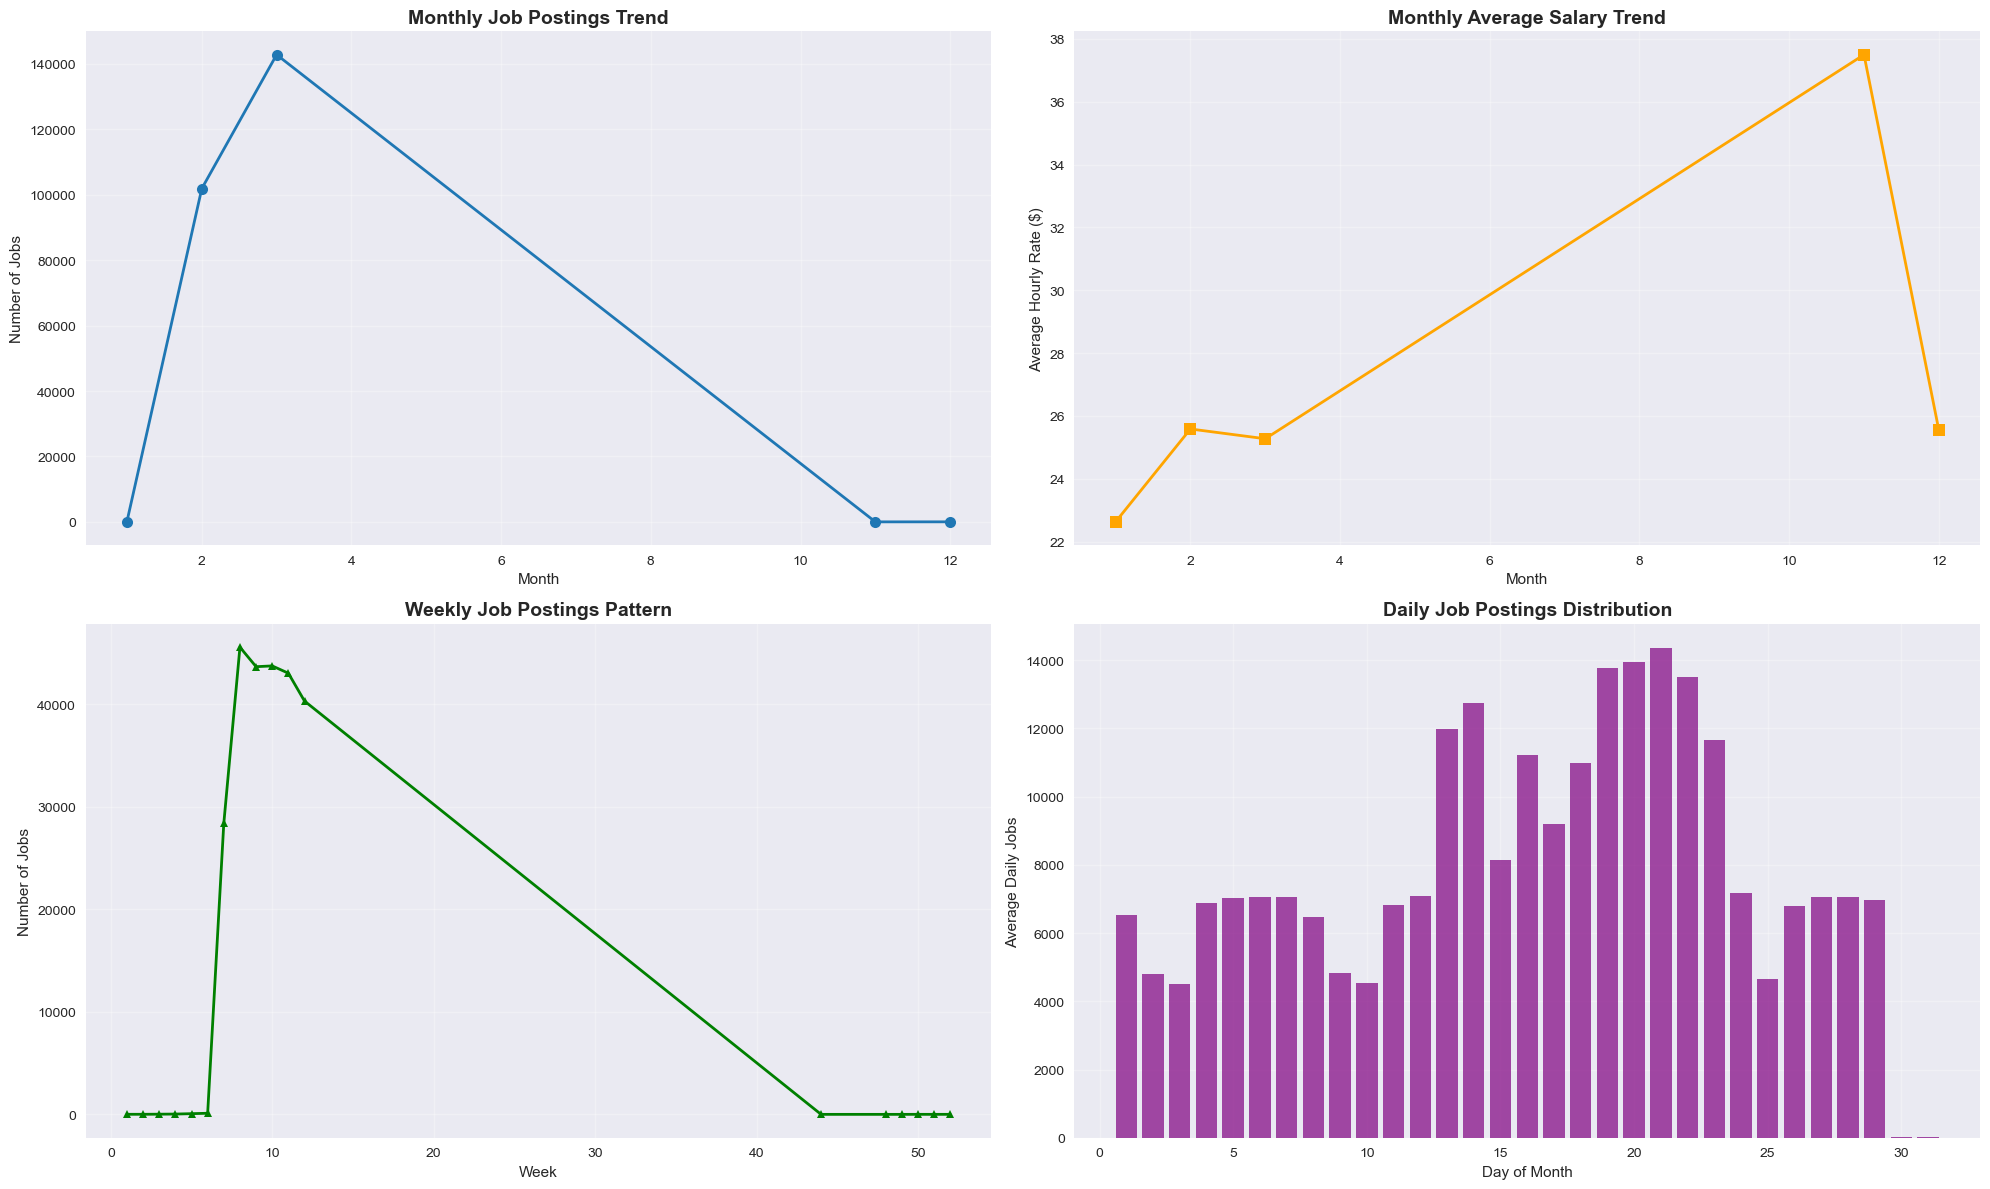

In [39]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Monthly job postings
ax1.plot(monthly_trends.index, monthly_trends['job_count'], marker='o', linewidth=2, markersize=8)
ax1.set_title('Monthly Job Postings Trend', fontsize=14, fontweight='bold')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Jobs')
ax1.grid(True, alpha=0.3)

# Monthly average salary
ax2.plot(monthly_trends.index, monthly_trends['hourly_avg'], marker='s', color='orange', linewidth=2, markersize=8)
ax2.set_title('Monthly Average Salary Trend', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month')
ax2.set_ylabel('Average Hourly Rate ($)')
ax2.grid(True, alpha=0.3)

# Weekly trends
ax3.plot(weekly_trends.index, weekly_trends['weekly_jobs'], marker='^', color='green', linewidth=2, markersize=6)
ax3.set_title('Weekly Job Postings Pattern', fontsize=14, fontweight='bold')
ax3.set_xlabel('Week')
ax3.set_ylabel('Number of Jobs')
ax3.grid(True, alpha=0.3)

# Daily trends
ax4.bar(daily_trends.index, daily_trends['daily_jobs'], color='purple', alpha=0.7)
ax4.set_title('Daily Job Postings Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Day of Month')
ax4.set_ylabel('Average Daily Jobs')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Market dynamics summary

In [40]:
print("\nMarket Dynamics Summary:")
print(f"Total months analyzed: {len(monthly_trends)}")
print(f"Average monthly job postings: {monthly_trends['job_count'].mean():.0f}")
print(f"Peak month for job postings: Month {monthly_trends['job_count'].idxmax()} ({monthly_trends['job_count'].max()} jobs)")
print(f"Salary trend: {'Increasing' if monthly_trends['hourly_avg'].iloc[-1] > monthly_trends['hourly_avg'].iloc[0] else 'Decreasing'}")
print(f"Countries represented: {monthly_trends['unique_countries'].max()}")


Market Dynamics Summary:
Total months analyzed: 5
Average monthly job postings: 48966
Peak month for job postings: Month 3 (142834 jobs)
Salary trend: Increasing
Countries represented: 202


### **Task 7: Investigate trends in the remote work landscape**

In [41]:
def analyze_remote_work_trends(df):
    """Analyze remote work trends from job titles"""
    
    # Identify remote work keywords
    remote_keywords = [
        'remote', 'work from home', 'wfh', 'virtual', 'online', 
        'telecommute', 'telework', 'distributed', 'flexible location'
    ]
    
    # Create pattern for remote work detection
    remote_pattern = '|'.join(remote_keywords)
    df['is_remote'] = df['clean_title'].str.contains(remote_pattern, case=False, na=False)
    
    # Remote work analysis
    remote_stats = df.groupby('is_remote').agg({
        'clean_title': 'count',
        'hourly_avg': 'mean',
        'budget': 'mean',
        'country': 'nunique'
    }).rename(columns={
        'clean_title': 'job_count',
        'country': 'countries_represented'
    })
    
    # Remote work trends over time
    remote_monthly = df.groupby(['published_month', 'is_remote']).size().unstack(fill_value=0)
    remote_monthly['remote_ratio'] = remote_monthly[True] / (remote_monthly[True] + remote_monthly[False])
    
    # Remote work by country
    remote_by_country = df[df['is_remote']].groupby('country').agg({
        'clean_title': 'count',
        'hourly_avg': 'mean'
    }).rename(columns={'clean_title': 'remote_jobs'}).sort_values('remote_jobs', ascending=False)
    
    return remote_stats, remote_monthly, remote_by_country

# Perform remote work analysis
remote_stats, remote_monthly, remote_by_country = analyze_remote_work_trends(df_clean)

print("Remote Work Statistics:")
display(remote_stats)

print("\nTop Countries for Remote Work:")
display(remote_by_country.head(10))

Remote Work Statistics:


,job_count,hourly_avg,budget,countries_represented
is_remote,,,,
False,236551,25.527656,446.778209,211
True,8277,21.874049,374.745439,141



Top Countries for Remote Work:


,remote_jobs,hourly_avg
country,,
United States,3992,22.621117
United Kingdom,536,20.849813
Canada,420,17.832143
Australia,410,18.447561
India,352,20.856534
Philippines,206,34.371359
Unknown,161,22.891304
Spain,148,19.091216
Germany,144,19.774306


### Visualization for remote work trends

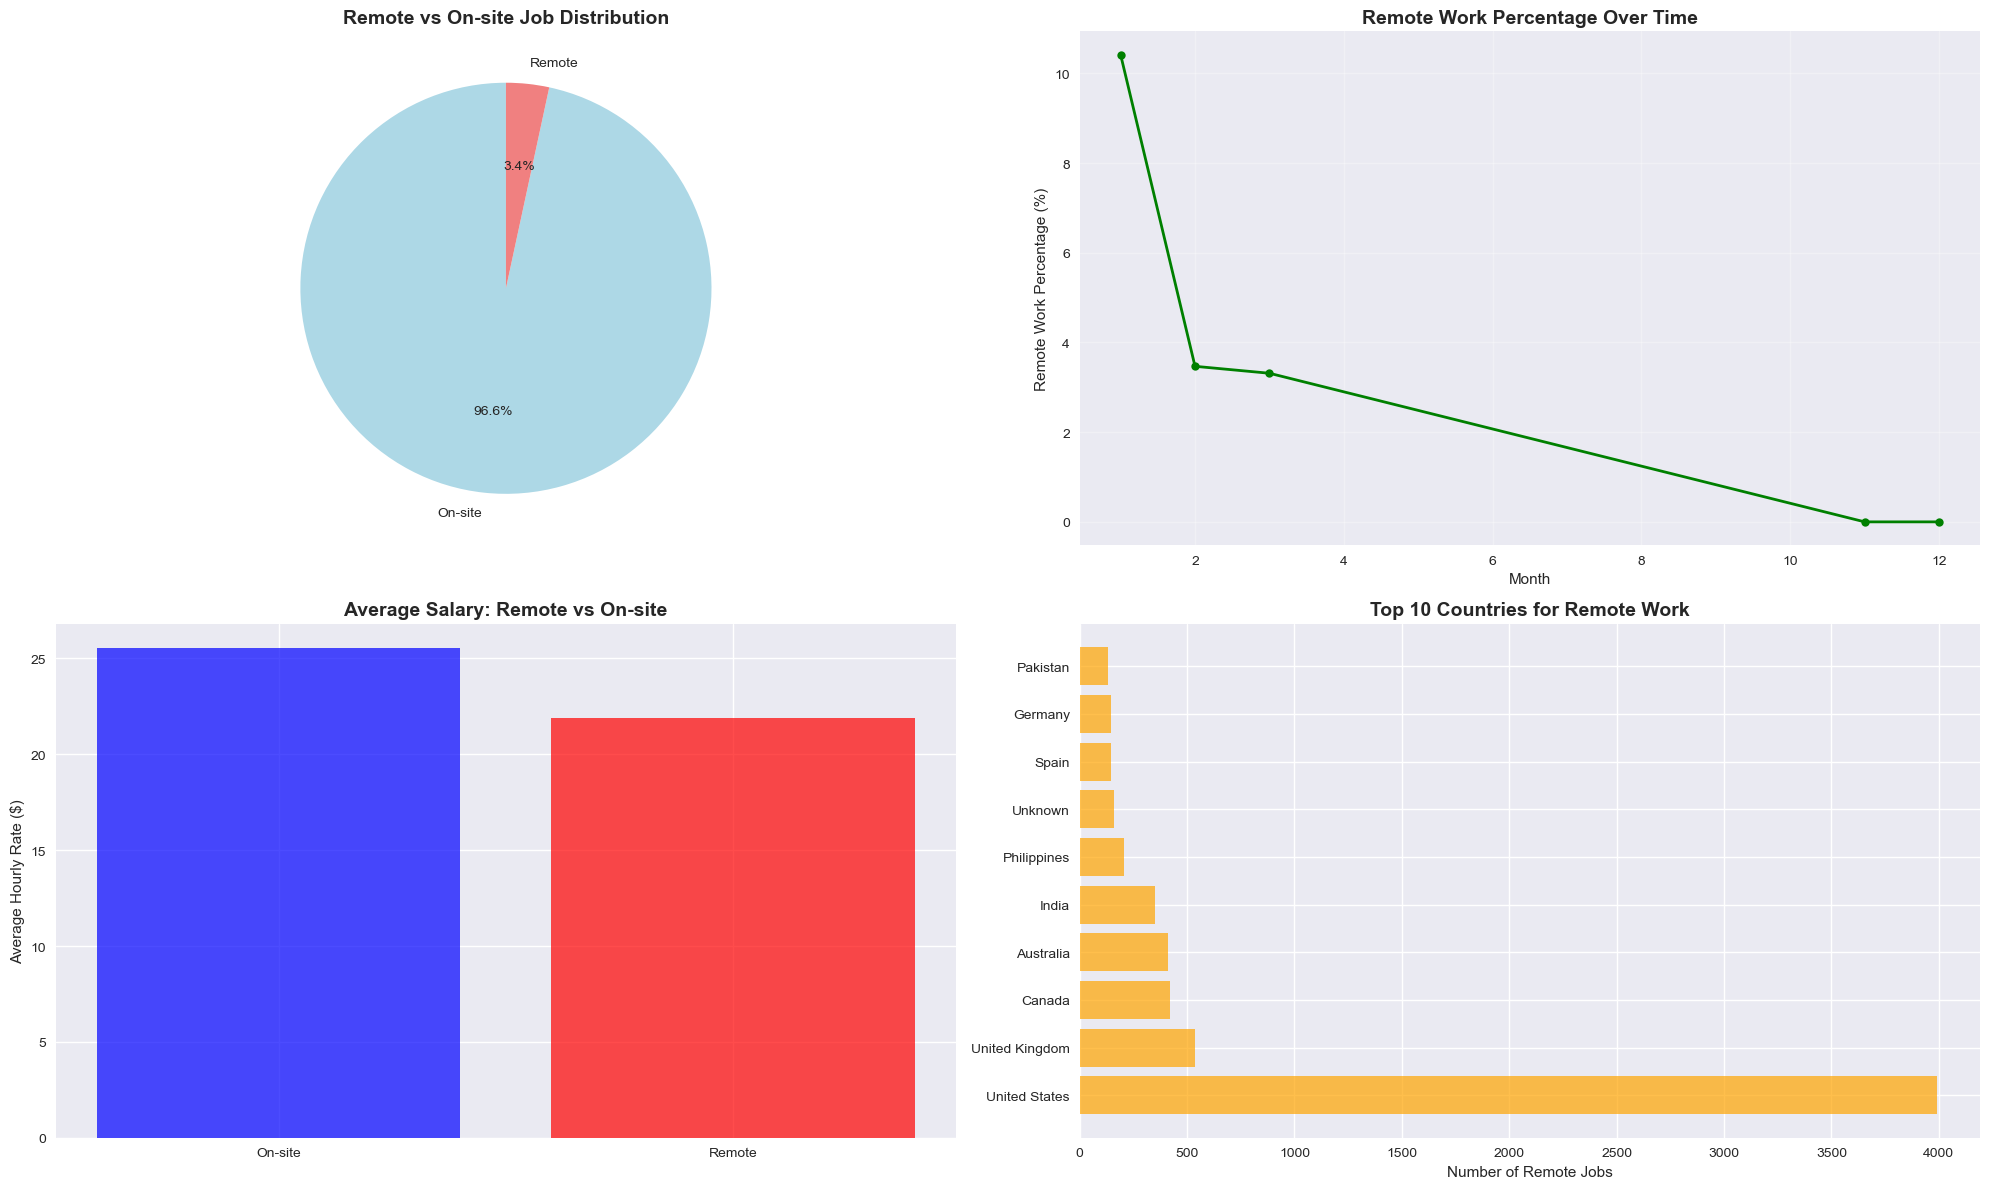

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Remote vs On-site comparison
labels = ['On-site', 'Remote']
sizes = [remote_stats.loc[False, 'job_count'], remote_stats.loc[True, 'job_count']]
colors = ['lightblue', 'lightcoral']
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Remote vs On-site Job Distribution', fontsize=14, fontweight='bold')

# Remote work growth over time
ax2.plot(remote_monthly.index, remote_monthly['remote_ratio'] * 100, 
         marker='o', linewidth=2, color='green', markersize=6)
ax2.set_title('Remote Work Percentage Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month')
ax2.set_ylabel('Remote Work Percentage (%)')
ax2.grid(True, alpha=0.3)

# Salary comparison
remote_salary = [remote_stats.loc[False, 'hourly_avg'], remote_stats.loc[True, 'hourly_avg']]
ax3.bar(labels, remote_salary, color=['blue', 'red'], alpha=0.7)
ax3.set_title('Average Salary: Remote vs On-site', fontsize=14, fontweight='bold')
ax3.set_ylabel('Average Hourly Rate ($)')

# Top countries for remote work
top_remote_countries = remote_by_country.head(10)
ax4.barh(range(len(top_remote_countries)), top_remote_countries['remote_jobs'], 
         color='orange', alpha=0.7)
ax4.set_yticks(range(len(top_remote_countries)))
ax4.set_yticklabels(top_remote_countries.index)
ax4.set_title('Top 10 Countries for Remote Work', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Remote Jobs')

plt.tight_layout()
plt.show()

### Remote work insights

In [43]:
print("\nRemote Work Insights:")
remote_jobs = remote_stats.loc[True, 'job_count']
total_jobs = remote_stats['job_count'].sum()
remote_percentage = (remote_jobs / total_jobs) * 100
print(f"Remote jobs: {remote_jobs} ({remote_percentage:.1f}% of total)")
print(f"Average remote salary: ${remote_stats.loc[True, 'hourly_avg']:.2f}")
print(f"Average on-site salary: ${remote_stats.loc[False, 'hourly_avg']:.2f}")
print(f"Salary premium for remote work: ${remote_stats.loc[True, 'hourly_avg'] - remote_stats.loc[False, 'hourly_avg']:.2f}")


Remote Work Insights:
Remote jobs: 8277 (3.4% of total)
Average remote salary: $21.87
Average on-site salary: $25.53
Salary premium for remote work: $-3.65


### **Task 8: Predict future job market trends**

### Importing required libraries

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

def predict_future_trends(df, forecast_months=6):
    """Predict future job market trends using multiple models (works with small datasets too)"""
    
    # Check if required columns exist
    required_columns = ['published_month', 'clean_title', 'hourly_avg', 'country']
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        return None

    # Ensure published_month is numeric (for adding new months)
    df['published_month'] = pd.to_numeric(df['published_month'], errors='coerce')
    df = df.dropna(subset=['published_month'])

    # Group by month
    monthly_data = df.groupby('published_month').agg({
        'clean_title': 'count',
        'hourly_avg': 'mean',
        'country': 'nunique'
    }).rename(columns={
        'clean_title': 'job_count',
        'country': 'unique_countries'
    }).reset_index()

    # Fill missing months automatically (important for small datasets)
    all_months = pd.Series(range(int(monthly_data['published_month'].min()),
                                 int(monthly_data['published_month'].max()) + 1))
    monthly_data = all_months.to_frame(name='published_month').merge(
        monthly_data, on='published_month', how='left'
    )
    monthly_data[['job_count', 'hourly_avg', 'unique_countries']] = monthly_data[['job_count', 'hourly_avg', 'unique_countries']].fillna(method='ffill').fillna(method='bfill')

    # Feature engineering for time series
    monthly_data['month_index'] = range(len(monthly_data))
    monthly_data['job_count_lag1'] = monthly_data['job_count'].shift(1)
    monthly_data['job_count_lag2'] = monthly_data['job_count'].shift(2)
    monthly_data['salary_lag1'] = monthly_data['hourly_avg'].shift(1)
    monthly_data['rolling_avg'] = monthly_data['job_count'].rolling(window=2, min_periods=1).mean()  # smaller window for small data

    # Fill remaining NaNs
    monthly_data = monthly_data.fillna(method='bfill').fillna(method='ffill')

    # Prepare features and target
    features = ['month_index', 'job_count_lag1', 'job_count_lag2', 'salary_lag1', 'rolling_avg']
    X = monthly_data[features]
    y_jobs = monthly_data['job_count']
    y_salary = monthly_data['hourly_avg']

    # Train models
    model_jobs = RandomForestRegressor(n_estimators=100, random_state=42)
    model_salary = RandomForestRegressor(n_estimators=100, random_state=42)

    model_jobs.fit(X, y_jobs)
    model_salary.fit(X, y_salary)

    # Make predictions
    future_predictions = []
    last_row = monthly_data.iloc[-1]

    for i in range(1, forecast_months + 1):
        next_month = {
            'month_index': last_row['month_index'] + i,
            'job_count_lag1': last_row['job_count'],
            'job_count_lag2': last_row['job_count_lag1'],
            'salary_lag1': last_row['hourly_avg'],
            'rolling_avg': last_row['rolling_avg']
        }

        job_pred = model_jobs.predict(pd.DataFrame([next_month]))[0]
        salary_pred = model_salary.predict(pd.DataFrame([next_month]))[0]

        future_predictions.append({
            'month': last_row['published_month'] + i,
            'predicted_jobs': max(0, job_pred),
            'predicted_salary': max(0, salary_pred)
        })

        # Update last_row for next prediction
        last_row = {
            'month_index': next_month['month_index'],
            'job_count': job_pred,
            'job_count_lag1': job_pred,
            'job_count_lag2': next_month['job_count_lag1'],
            'hourly_avg': salary_pred,
            'rolling_avg': (job_pred + next_month['job_count_lag1'] + next_month['job_count_lag2']) / 3,
            'published_month': last_row['published_month'] + 1
        }

    return pd.DataFrame(future_predictions), model_jobs, model_salary

### Perform future trend prediction

✅ Future Job Market Trends Prediction:


,month,predicted_jobs,predicted_salary
0,13.0,9399.13,28.831386
1,15.0,11442.69,28.833213
2,17.0,11442.69,28.833213
3,19.0,11442.69,28.833213
4,21.0,11442.69,28.833213
5,23.0,11442.69,28.833213


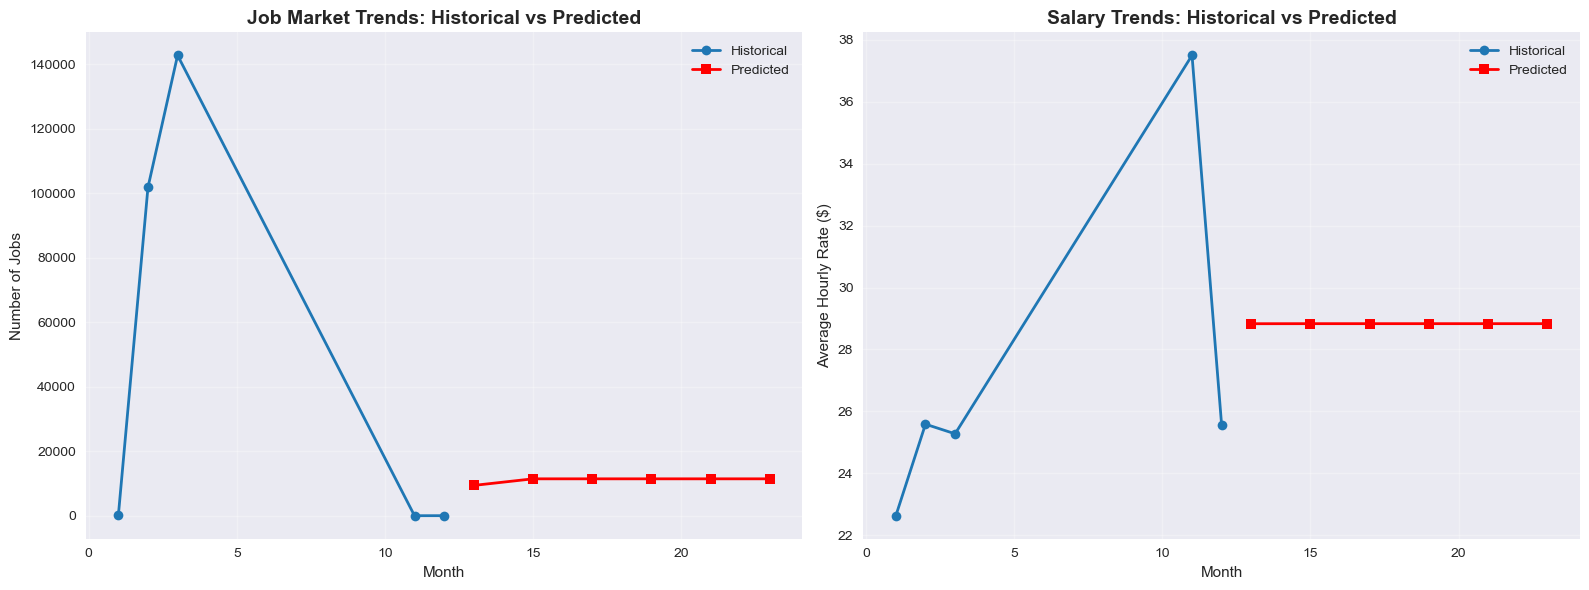

In [53]:
result = predict_future_trends(df_clean, forecast_months=6)

if result is not None:
    future_trends, jobs_model, salary_model = result
    print("Future Job Market Trends Prediction:")
    display(future_trends)
    
    # Visualization for future trends
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Historical job trends
    historical_data = df_clean.groupby('published_month').size()
    ax1.plot(historical_data.index, historical_data.values, marker='o', label='Historical', linewidth=2)
    ax1.plot(future_trends['month'], future_trends['predicted_jobs'], marker='s', 
             color='red', label='Predicted', linewidth=2)
    ax1.set_title('Job Market Trends: Historical vs Predicted', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Number of Jobs')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Salary trends
    historical_salary = df_clean.groupby('published_month')['hourly_avg'].mean()
    ax2.plot(historical_salary.index, historical_salary.values, marker='o', label='Historical', linewidth=2)
    ax2.plot(future_trends['month'], future_trends['predicted_salary'], marker='s', 
             color='red', label='Predicted', linewidth=2)
    ax2.set_title('Salary Trends: Historical vs Predicted', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Average Hourly Rate ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to generate predictions.")

### Trend analysis and insights

In [55]:
print("\nFuture Market Insights:")
job_growth = ((future_trends['predicted_jobs'].iloc[-1] - future_trends['predicted_jobs'].iloc[0]) / 
                  future_trends['predicted_jobs'].iloc[0]) * 100
salary_growth = ((future_trends['predicted_salary'].iloc[-1] - future_trends['predicted_salary'].iloc[0]) / 
                     future_trends['predicted_salary'].iloc[0]) * 100
    
print(f"Predicted job growth over {len(future_trends)} months: {job_growth:.1f}%")
print(f"Predicted salary growth over {len(future_trends)} months: {salary_growth:.1f}%")
print(f"Expected average monthly jobs: {future_trends['predicted_jobs'].mean():.0f}")
print(f"Expected average salary: ${future_trends['predicted_salary'].mean():.2f}")


Future Market Insights:
Predicted job growth over 6 months: 21.7%
Predicted salary growth over 6 months: 0.0%
Expected average monthly jobs: 11102
Expected average salary: $28.83


### Emerging opportunities

In [56]:
    if job_growth > 0:
        print("Market Outlook: POSITIVE - Growing job opportunities")
    else:
        print("Market Outlook: CAUTIOUS - Potential market contraction")
        
    if salary_growth > 0:
        print("Salary Outlook: POSITIVE - Increasing compensation trends")
    else:
        print("Salary Outlook: STABLE - Maintained compensation levels")

Market Outlook: POSITIVE - Growing job opportunities
Salary Outlook: POSITIVE - Increasing compensation trends
